#Preprocessing

### Install rasterio and geopandas

In [2]:
!pip install rasterio geopandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [242]:
import json, os, sys
import numpy as np

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import patches

import torch
from torch.utils.data import Dataset

import rasterio

BASE_DIR = '/content/drive/Shareddrives/한주프로젝트는 9조에서/AOI_5_Khartoum_Train'

class SpaceNetDataset(Dataset):

    def __init__(self, geojson_dir, image_dir, transform=None):
        self.geojson_dir = geojson_dir
        self.image_dir = image_dir
        self.transform = transform

        self.geojsons = sorted(os.listdir(geojson_dir), key=lambda x:int(x[x.index('_img')+4:-8]))
        self.images = sorted(os.listdir(image_dir), key=lambda x:int(x[x.index('_img')+4:-4]))
        
        
    def __getitem__(self, idx):
        geojson_dir = os.path.join(self.geojson_dir, self.geojsons[idx])
        img_dir = os.path.join(self.image_dir, self.images[idx])

        self.file_name = self.geojsons[idx][self.geojsons[idx].index('AOI'):dataset.geojsons[idx].index('.geojson')]

        json_file = self.load_json(geojson_dir)
        img_file = self.load_tif(img_dir)

        self.width = img_file.width
        self.height = img_file.height

        img = img_file.read()
        img = img/np.max(img)
        
        polygons = self.get_buildings(json_file, img_file)
        mask = self._mask(polygons)

        if self.transform:
            img = self.transform(img)
            
        return img, mask, polygons

    def __len__(self):
        return len(self.geojsons)

    def load_json(self, path):
        with open(path) as f:
            json_data = json.load(f)
        return json_data
    
    def load_tif(self, path):
        return rasterio.open(path)

    def _mask(self, polygons):
        img = Image.new('L', (self.height, self.width), 0)
        for i in range(len(polygons)):
            ImageDraw.Draw(img).polygon(polygons[i], outline=1, fill=1)
        mask = np.array(img)
        return mask

    def get_buildings(self, json_data, tif_data):
        factor_x = self.width / (tif_data.bounds.right - tif_data.bounds.left)
        factor_y = self.height / (tif_data.bounds.top - tif_data.bounds.bottom)
        polygons = []
        for ply in json_data['features']:
            poly = []
            if ply['geometry']['type'] == 'Polygon':
                for coord in ply['geometry']['coordinates']:        
                    for x,y,z in coord:
                        poly.append((min((x-tif_data.bounds.left)*factor_x, tif_data.width), min((tif_data.bounds.top-y)*factor_y, tif_data.height)))
                        
            elif ply['geometry']['type'] == 'MultiPolygon':
                for coords in ply['geometry']['coordinates']:
                    for coord in coords:
                        for x,y,z in coord:
                            poly.append((min((x-tif_data.bounds.left)*factor_x, tif_data.width), min((tif_data.bounds.top-y)*factor_y, tif_data.height)))
            else:
                tp = ply['geometry']['type']
                raise Exception(f'The type {tp} is not supported') 
            polygons.append(poly)
        return polygons

    def show_image(self, idx):
        img, _, polygons = self[idx]
        
        fig = plt.figure(figsize=(8,4), dpi=150)
        ax = fig.add_subplot(1,2,1)
        ax.set_xticks(range(0, self.width, 100))
        ax.set_yticks(range(0, self.height, 100))
        ax.set_title(self.file_name, fontsize=7)
        ax.imshow(img.transpose(1,2,0))

        ax = fig.add_subplot(1,2,2)
        ax.set_xticks(range(0, self.width, 100))
        ax.set_yticks(range(0, self.height, 100))
        ax.set_title(self.file_name, fontsize=7)
        ax.imshow(img.transpose(1,2,0))
        
        for i in range(len(polygons)):
            p = np.array(polygons[i])
            ax.plot(p[:,0],p[:,1])
        plt.show()

In [243]:
geojson_dir = '/content/drive/Shareddrives/한주프로젝트는 9조에서/AOI_5_Khartoum_Train/geojson/buildings'
imge_dir = '/content/drive/Shareddrives/한주프로젝트는 9조에서/AOI_5_Khartoum_Train/RGB-PanSharpen'

dataset = SpaceNetDataset(geojson_dir, imge_dir)

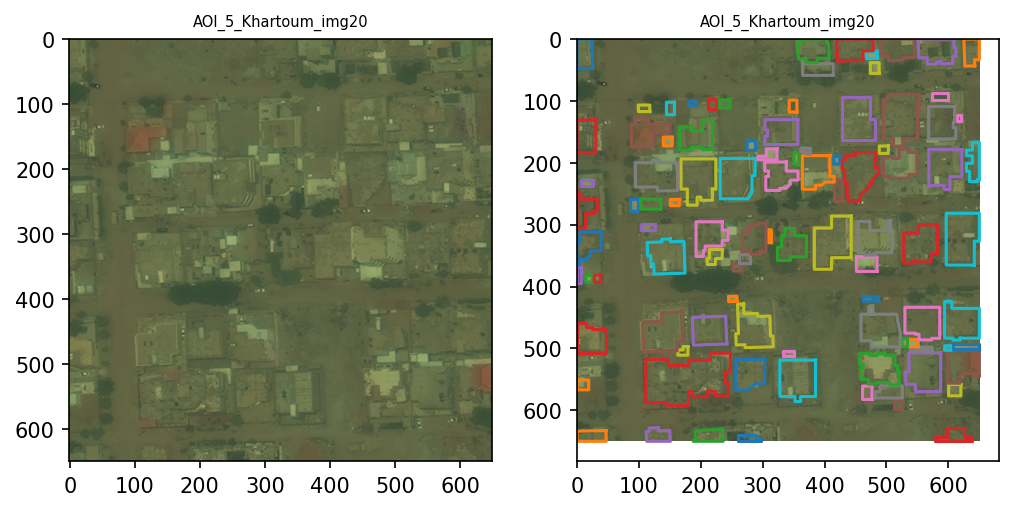

In [244]:
dataset.show_image(13)

In [245]:
img, mask, polygon = dataset[13]

In [247]:
polygon

[[(296.6970370584977, 646.6003332770474),
  (296.6970370584977, 649.9999860898101),
  (259.72472923980615, 649.9999860898101),
  (259.7248148259945, 640.2388517935663),
  (288.5103703934395, 640.2388517935663),
  (288.5103703934395, 646.6003332770474),
  (296.6970370584977, 646.6003332770474)],
 [(46.79074075284863, 632.6877407050537),
  (47.10788423962889, 649.9999860898101),
  (4.792216006729817e-06, 649.9999860898101),
  (4.792216006729817e-06, 633.483459549943),
  (0.9677778091651699, 633.4669999919465),
  (46.79074075284863, 632.6877407050537)],
 [(234.64444446344842, 630.4244073778759),
  (236.06665783734687, 649.9999860898101),
  (187.68093564440923, 649.9999860898101),
  (187.56296298659393, 648.3762592360964),
  (191.6977778145632, 648.0973703530801),
  (190.63000001554565, 633.3932962630652),
  (234.64444446344842, 630.4244073778759)],
 [(625.7514815133943, 629.0425555176121),
  (625.7514815133943, 642.274407402411),
  (638.0755555610701, 642.274407402411),
  (638.07555556107

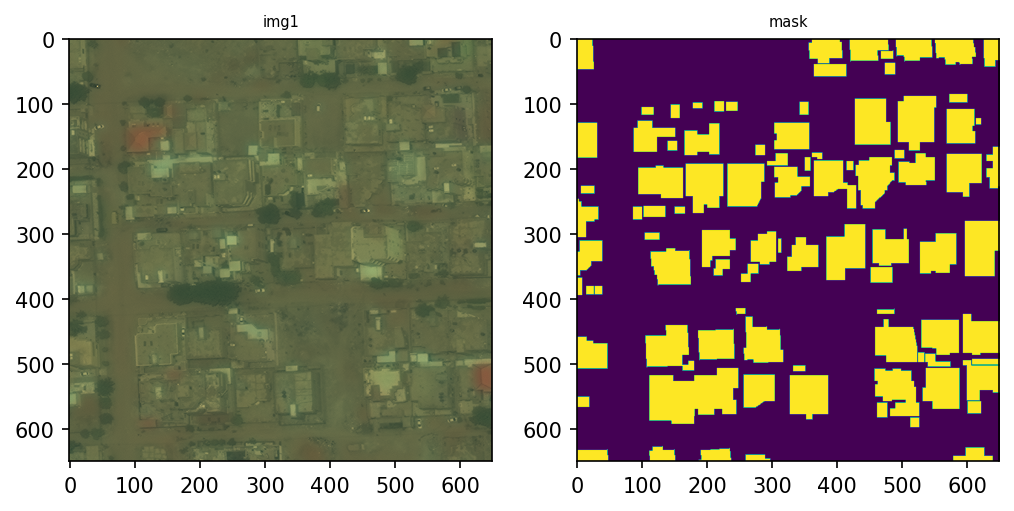

In [246]:
img = img/np.max(img)
fig = plt.figure(figsize=(8,4), dpi=150)
ax = fig.add_subplot(1,2,1)
ax.set_xticks(range(0, img.shape[1], 100))
ax.set_yticks(range(0, img.shape[2], 100))
ax.set_title('img1', fontsize=7)
ax.imshow(img.transpose(1,2,0))

ax = fig.add_subplot(1,2,2)
ax.set_xticks(range(0, mask.shape[1], 100))
ax.set_yticks(range(0, mask.shape[0], 100))
ax.set_title('mask', fontsize=7)
ax.imshow(mask)

In [7]:
import geopandas as gpd

SummaryData = gpd.read_file(os.path.join(BASE_DIR, 'summaryData/AOI_5_Khartoum_Train_Building_Solutions.csv'))
SummaryData

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
0,AOI_5_Khartoum_img1240,1,"POLYGON ((508.93 461.14 0,510.93 460.63 0,512....",POLYGON ((32.559167521982651 15.63541610998623...,None
1,AOI_5_Khartoum_img1240,2,"POLYGON ((650.0 566.61 0,650.0 430.92 0,616.37...",POLYGON ((32.559548400025243 15.63513134788442...,None
2,AOI_5_Khartoum_img1240,3,"POLYGON ((291.55 430.09 0,290.14 415.95 0,274....",POLYGON ((32.558580596912037 15.63549995555238...,None
3,AOI_5_Khartoum_img1240,4,"POLYGON ((432.58 464.83 0,484.8 461.22 0,481.2...",POLYGON ((32.55896136042162 15.635406169418781...,None
4,AOI_5_Khartoum_img1240,5,"POLYGON ((581.21 408.69 0,525.15 405.15 0,522....",POLYGON ((32.559362671096714 15.63555774853030...,None
...,...,...,...,...,...
25546,AOI_5_Khartoum_img947,1,"POLYGON ((650.0 599.58 0,650.0 563.32 0,649.76...",POLYGON ((32.554283400024296 15.70348732101684...,None
25547,AOI_5_Khartoum_img459,1,"POLYGON ((610.99 641.2 0,607.49 650.0 0,646.3 ...",POLYGON ((32.541893068189388 15.69635495529645...,None
25548,AOI_5_Khartoum_img459,2,"POLYGON ((647.22 650.0 0,650 650 0,650.0 648.6...",POLYGON ((32.541990889077731 15.69633119996875...,None
25549,AOI_5_Khartoum_img459,3,"POLYGON ((597.82 638.76 0,498.1 611.91 0,488.2...",POLYGON ((32.541857511972111 15.69636154519557...,None


In [ ]:
taehwak@hanyang.ac.kr